This homework is made by:
* Masoumeh Bakhtiariziabari (11813105)
* Marianne de Heer Kloots (11138351)
* Tharangni Sivaji (11611065)

# Theoretical Part [15 pts]

## 1. Hypothesis Testing – The problem of multiple comparisons [5 points]
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):
* P(m<sup>th</sup> experiment gives significant result | m experiments lacking power to reject H<sub>0</sub>)?
* P(at least one significant result | m experiments lacking power to reject H<sub>0</sub>)?

<div style="background-color: lightyellow">
<ol>
<li><ul>
        <li> $$
        P(m^{\text{th}}\text{ experiment gives significant result} \mid m \text{ experiments lacking power to reject } H_0) \\
        \approx P(m^{\text{th}}\text{ experiment gives significant result} \mid H_0 \text{ is true in all m experiments}) \\
        \text{(i.e. only the } m^{\text{th}} \text{ result is significant whereas } (m-1) \text{ results are not significant)} \\
        = \boldsymbol{((1 - \alpha)^{m-1})\cdot\alpha}
        $$<br><br>
        <li> $$
        P(\text{at least one significant result} \mid m \text{ experiments lacking power to reject } H_0)\\
        = 1 - P(\text{no significant result})\\
        = \boldsymbol{1 - (1 - \alpha)^m}
        $$
    </ul>
</ol>
</div>

## 2. Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

**Answer:**
- All interleaving comparison methods will fail to be sensitive if user clicks are not correlated with relevance.
- However, Team Draft Interleaving can suffer from insensitivity even when such correlations exist.
- Consider two lists $A$ and $B$ such that $A \in \{a, b, c\}$ and $B \in \{b, c, d\}$. 
- Assume $c$ is considered as the most relevant document. Then, since rank of $c^B > c^A \Rightarrow$ B should win.
- The interleaved comparisions for both the lists is given below:
<table><tr><th>a)</th><th></th><th></th><th>b)</th><th></th><th></th></tr><tr><td></td><td>a</td><td>A</td><td></td><td>b</td><td>B</td></tr><tr><td></td><td>b</td><td>B</td><td></td><td>a</td><td>A</td></tr><tr><td></td><td>c</td><td>A</td><td></td><td>c</td><td>B</td></tr><tr><th>c)</th><td></td><td></td><th>d)</th><td></td><td></td></tr><tr><td></td><td>b</td><td>B</td><td></td><td>a</td><td>A</td></tr><tr><td></td><td>a</td><td>A</td><td></td><td>b</td><td>B</td></tr><tr><td></td><td>c</td><td>A</td><td></td><td>c</td><td>B</td></tr></table>
- However, all possible 4 interleaved lists place $c$ at the same rank, i.e. third.
- This results in a tie.
- Hence Team Draft Interleaving fails to detect the preference for $B$.

# Experimental Part [85 pts]

In [1]:
from collections import Counter
import numpy as np
from itertools import product
from pprint import pprint
import random
from scipy import stats
from itertools import combinations
import math
import matplotlib.pyplot as plt

## <font color='purple'>[Based on Lecture 1]</font>
### Step 1: <font color='darkred'>Simulate Rankings of Relevance for *E* and *P* *(5 points)*</font>

In [2]:
# define collections of algorithms and relevance grades
algorithms = ['P', 'E']
relevance_grades = ['N', 'HR', 'R']

# all possible ranking sequences
# list of rankings [('HR', 'HR', 'HR', 'HR', 'HR') ... ('N', 'N', 'N', 'N', 'N')]
rankings = [ranking for ranking in product(relevance_grades, repeat=5)]

# all algorithms paired with all rankings 
# (list of lists with elements e.g. ('P', ('HR', 'HR', 'HR', 'HR', 'HR')))
algorithm_rankings = [list(product(alg, rankings)) for alg in algorithms]

# all possible pairs of P and E with their rankings
all_ranking_pairs = [pair for pair in product(*algorithm_rankings)]

# all ranking pairs except equals
ranking_pairs = [pair for pair in product(*algorithm_rankings) if pair[0][1] != pair[1][1]]

# pretty print
print('number of combinations:', len(all_ranking_pairs))
print('number of non-equal combinations:', len(ranking_pairs))
pprint(random.sample(ranking_pairs, 10))

number of combinations: 59049
number of non-equal combinations: 58806
[(('P', ('R', 'HR', 'HR', 'HR', 'HR')), ('E', ('R', 'HR', 'R', 'R', 'R'))),
 (('P', ('R', 'R', 'HR', 'N', 'HR')), ('E', ('N', 'HR', 'N', 'HR', 'N'))),
 (('P', ('HR', 'R', 'N', 'HR', 'N')), ('E', ('N', 'N', 'R', 'N', 'R'))),
 (('P', ('HR', 'N', 'N', 'N', 'R')), ('E', ('R', 'R', 'HR', 'R', 'HR'))),
 (('P', ('HR', 'N', 'N', 'R', 'HR')), ('E', ('N', 'N', 'HR', 'HR', 'N'))),
 (('P', ('N', 'R', 'N', 'HR', 'N')), ('E', ('R', 'HR', 'HR', 'R', 'N'))),
 (('P', ('HR', 'HR', 'N', 'R', 'N')), ('E', ('R', 'HR', 'R', 'HR', 'N'))),
 (('P', ('HR', 'N', 'N', 'R', 'HR')), ('E', ('N', 'R', 'HR', 'R', 'R'))),
 (('P', ('R', 'HR', 'R', 'R', 'N')), ('E', ('N', 'HR', 'R', 'HR', 'N'))),
 (('P', ('HR', 'N', 'R', 'HR', 'N')), ('E', ('R', 'N', 'HR', 'R', 'N')))]


**explanation/analysis:**

We find 59049 different ranking pairs. This makes sense: each ranking pair consists of 10 relevance values (5 produced by each algorithm), all of which can take on any of the 3 grades (N, R, HR). So there should be 310 = 59049 different combinations, which matches our finding.

We then exclude all ranking pairs which have exactly the same relevance grade sequences, which leaves us with 58806 different combinations.

We have printed a randomly selected sample of 10 ranking pairs as an example.


### Step 2: <font color='darkred'>Implement Evaluation Measures *(10 points)*</font>
Implement 1 binary and 2 multi-graded evaluation measures out of the 7 measures mentioned above. 

(Note 2: Some of the aforementioned measures require the total number of relevant and highly relevant documents in the entire collection – pay extra attention on how to find this)

In [3]:
#p@K function

def precision(k,_ranking_pairs):
    
    def calc_precision(i,x):
        rel_counter = 0.0
        prec = 0.0
        for j in range(k):
            if _ranking_pairs[i][x][1][j] == 'HR' or _ranking_pairs[i][x][1][j] == 'R':
                rel_counter += 1
                prec += rel_counter/(1.0+j)
        return prec
    
    prec_list = []
    for i in range(len(_ranking_pairs)):
        p_prec = calc_precision(i,0)
        e_prec = calc_precision(i,1)
        prec_list.append((p_prec/k,e_prec/k))
        #print(p_prec,e_prec)
    
    return prec_list


In [4]:
prec = precision(3,ranking_pairs)

print('mean of all precision values for P & E (should be equal):\n', 
      np.mean(prec, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(prec, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 10)
print("Precision at K=3 for 10 random queries:")
print("query number \t P \t E")
for i in random_query_index_list:
    print("query ",i,": \t",'%.3f'%prec[i][0],"\t",'%.3f'%prec[i][1])

mean of all precision values for P & E (should be equal):
 [ 0.58024691  0.58024691] 

mean of a random sample of 100 pairs:
 [ 0.59333333  0.53666667] 

Precision at K=3 for 10 random queries:
query number 	 P 	 E
query  56701 : 	 1.000 	 0.389
query  53727 : 	 0.667 	 0.000
query  54620 : 	 1.000 	 0.333
query  36627 : 	 1.000 	 0.333
query  5243 : 	 0.111 	 0.333
query  48204 : 	 1.000 	 0.389
query  52143 : 	 1.000 	 0.667
query  34611 : 	 0.667 	 0.000
query  57193 : 	 1.000 	 0.333
query  30455 : 	 1.000 	 1.000


In [5]:
def average_prec(k_max,_ranking_pairs):
    temp_list = []
    ap_list = [[0,0] for i in range(len(_ranking_pairs))]
    for k in range(1,k_max+1):
        temp_list = precision(k,_ranking_pairs)
        #print(k,temp_list)
        for index,item in enumerate(temp_list):
            ap_list[index] = (np.array(ap_list[index])+np.array(item)).tolist()
    #print(ap_list)
    for item in ap_list:
        item[:] = [i / k_max for i in item]
    return ap_list       
    

In [6]:
k_max = 5
avg_prec = average_prec(k_max,ranking_pairs)

print('mean of all AP values for P & E (should be equal):\n', 
      np.mean(avg_prec, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(avg_prec, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 10)
print("Average Precision for 10 random queries:")
print("query number \t P \t\t\t\t AP \t E \t\t\t\t AP")
for i in random_query_index_list:
    print("query ",i,": \t",ranking_pairs[i][0][1], "\t",'%.3f'%avg_prec[i][0],'\t',ranking_pairs[i][1][1],'\t','%.3f'%avg_prec[i][1])

mean of all AP values for P & E (should be equal):
 [ 0.59282716  0.59282716] 

mean of a random sample of 100 pairs:
 [ 0.60443833  0.60221111] 

Average Precision for 10 random queries:
query number 	 P 				 AP 	 E 				 AP
query  15285 : 	 ('N', 'R', 'HR', 'N', 'N') 	 0.233 	 ('N', 'HR', 'HR', 'HR', 'N') 	 0.300
query  9731 : 	 ('N', 'HR', 'HR', 'HR', 'HR') 	 0.332 	 ('N', 'HR', 'R', 'R', 'HR') 	 0.332
query  6226 : 	 ('N', 'N', 'R', 'R', 'HR') 	 0.121 	 ('R', 'N', 'HR', 'R', 'N') 	 0.629
query  19031 : 	 ('N', 'R', 'R', 'R', 'N') 	 0.300 	 ('HR', 'R', 'R', 'HR', 'N') 	 0.960
query  766 : 	 ('N', 'N', 'N', 'HR', 'N') 	 0.022 	 ('N', 'HR', 'HR', 'HR', 'R') 	 0.332
query  37605 : 	 ('HR', 'R', 'R', 'N', 'R') 	 0.902 	 ('HR', 'N', 'HR', 'HR', 'R') 	 0.661
query  7737 : 	 ('N', 'HR', 'N', 'HR', 'HR') 	 0.197 	 ('R', 'R', 'R', 'N', 'R') 	 0.902
query  30438 : 	 ('HR', 'HR', 'HR', 'R', 'R') 	 1.000 	 ('R', 'HR', 'N', 'N', 'N') 	 0.713
query  27315 : 	 ('HR', 'HR', 'N', 'HR', 'HR') 	 0.813 

<div style="background-color: lightyellow">
explanation/analysis?
</div>

In [7]:
#-------------calc ideal dcg based on ground truth [10 HR, 10 R, 10 N]
def calc_ideal_dgc(k):
    idcg_rel = [0.9]*10 + [0.6]*10 + [0.1]*10
    idcg = 0
    for index in range(min(k, len(idcg_rel))):
        idcg += ((2**idcg_rel[index]) - 1)/(math.log2(2+index))
    return idcg
        

In [8]:
# I used the second formula of DCG from slide 6 of http://www.cs.cornell.edu/courses/cs4300/2013fa/lectures/evaluation-1-4pp.pdf
#nDCG is a way to calculate this measure across many independent ____queries____(http://curtis.ml.cmu.edu/w/courses/index.php/Normalized_discounted_cumulative_gain)
#Normalize DCG at rank n by the DCG value at rank n of the ideal ranking(stanford slide)

def ndcg(max_k,query_index,method):    
    all_dcg_k = []
    
    #--------------------make dcg list for all k-----------------------------
    for r in range(0,max_k):
        if ranking_pairs[query_index][method][1][r] == 'HR':
            rel_num = 0.9
        elif ranking_pairs[query_index][method][1][r] == 'R':
            rel_num = 0.6
        else:
            rel_num = 0.1
            
        if len(all_dcg_k) > 0:   
            all_dcg_k.append((((2**rel_num) - 1)/(math.log2(2+r))) + all_dcg_k[-1])
        else:
            all_dcg_k.append(((2**rel_num) - 1)/(math.log2(2+r)))
            
            
    #----------------calculate ideal dcg------------------------------------      
    idcg = calc_ideal_dgc(max_k)
        
    #--------------------------convert dcg to ndcg--------------------------   
    if(idcg == 0):
        all_dcg_k[:] = [0 for x in all_dcg_k]
    else:
        all_dcg_k[:] = [x / idcg for x in all_dcg_k]
     
    return all_dcg_k

#-----------------------call ndcg function for all 59000 queries------------------
ndcg_list = []
max_k = 5
for i in range(len(ranking_pairs)):
    p_dcg = ndcg(max_k,i,0)
    e_dcg = ndcg(max_k,i,1)
    ndcg_list.append((p_dcg[-1],e_dcg[-1]))

    
    

In [9]:
print('mean of all NDCD values for P & E (should be equal):\n', 
      np.mean(ndcg_list, axis=0),'\n')
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(ndcg_list, 100), axis=0),'\n')
random_query_index_list = random.sample(range(len(ranking_pairs)), 10)
print("NDCG@5 for 10 random queries:")
print("query number \t P \t\t\t\t NDCG \t E \t\t\t\t NDCG")
for index in random_query_index_list:
    print("query %d"%index,":",'\t',ranking_pairs[index][0][1], "\t", '%.3f'%ndcg_list[index][0],'\t',ranking_pairs[index][1][1], "\t",'%.3f'%ndcg_list[index][1],'\n')

mean of all NDCD values for P & E (should be equal):
 [ 0.55944776  0.55944776] 

mean of a random sample of 100 pairs:
 [ 0.55657907  0.55550462] 

NDCG@5 for 10 random queries:
query number 	 P 				 NDCG 	 E 				 NDCG
query 11441 : 	 ('N', 'HR', 'R', 'N', 'R') 	 0.433 	 ('N', 'R', 'HR', 'HR', 'R') 	 0.549 

query 5505 : 	 ('N', 'N', 'R', 'HR', 'HR') 	 0.424 	 ('R', 'N', 'R', 'N', 'R') 	 0.411 

query 9356 : 	 ('N', 'HR', 'HR', 'N', 'R') 	 0.502 	 ('HR', 'R', 'R', 'R', 'R') 	 0.733 

query 36136 : 	 ('HR', 'R', 'HR', 'HR', 'R') 	 0.860 	 ('N', 'R', 'R', 'R', 'N') 	 0.354 

query 27839 : 	 ('HR', 'HR', 'N', 'R', 'HR') 	 0.785 	 ('N', 'N', 'HR', 'N', 'N') 	 0.238 

query 57527 : 	 ('R', 'R', 'R', 'HR', 'N') 	 0.587 	 ('R', 'N', 'HR', 'N', 'R') 	 0.480 

query 58566 : 	 ('R', 'R', 'R', 'R', 'R') 	 0.595 	 ('N', 'N', 'N', 'N', 'R') 	 0.150 

query 55323 : 	 ('R', 'R', 'HR', 'HR', 'N') 	 0.656 	 ('HR', 'R', 'HR', 'HR', 'N') 	 0.793 

query 18822 : 	 ('N', 'R', 'R', 'HR', 'R') 	 0.481 	 ('R

In [10]:
# ERR

def numerical(relevance_sequence):
    """
    Convert a relevance grade sequence to a sequence of numerical 
    values, based on the relevance grades given.
    E.g. ['HR', 'HR', 'HR', 'R', 'N'] returns [2, 2, 2, 1, 0]
    """
    numerical_relevance_sequence = [0.6 if grade == 'R' \
                                    else 0.9 if grade == 'HR' else 0.1 \
                                    for grade in relevance_sequence]
    return numerical_relevance_sequence

def R_function(g, g_max):
    return (2**g - 1)/(2**g_max)

def ERR(relevance_sequence):
    """
    Compute the ERR based on Algorithm 2 in 
    https://pdfs.semanticscholar.org/7e3c/f6492128f915112ca01dcb77c766129e65cb.pdf
    """
    p = 1
    ERR = 0
    n = len(relevance_sequence)
    g_max = max(relevance_sequence)
    
    for r in range(1, n + 1):
        g = relevance_sequence[r - 1]
        R = R_function(g, g_max)
        ERR = ERR + p * (R/r)
        p = p * (1 - R)
    return ERR

ERR_list = []
for P, E in ranking_pairs:
    ERR_P = ERR(numerical(P[1]))
    ERR_E = ERR(numerical(E[1]))
    ERR_list.append((ERR_P, ERR_E))
    
print('mean of all ERR values for P & E (should be equal):\n', 
      np.mean(ERR_list, axis=0))
print('mean of a random sample of 100 pairs:\n', 
      np.mean(random.sample(ERR_list, 100), axis=0),'\n')

random_query_index_list = random.sample(range(len(ranking_pairs)), 10)
print("ERR for 10 random queries:")
print("query number \t P \t\t\t\t ERR \t E \t\t\t\t ERR")
for index in random_query_index_list:
    print("query %d"%index,":",'\t',ranking_pairs[index][0][1], "\t", '%.3f'%ERR_list[index][0],'\t',ranking_pairs[index][1][1], "\t",'%.3f'%ERR_list[index][1],'\n')


mean of all ERR values for P & E (should be equal):
 [ 0.45258501  0.45258501]
mean of a random sample of 100 pairs:
 [ 0.45379693  0.47160741] 

ERR for 10 random queries:
query number 	 P 				 ERR 	 E 				 ERR
query 40439 : 	 ('R', 'N', 'N', 'HR', 'R') 	 0.397 	 ('N', 'N', 'R', 'R', 'HR') 	 0.233 

query 1456 : 	 ('N', 'N', 'N', 'R', 'N') 	 0.163 	 ('N', 'N', 'N', 'HR', 'HR') 	 0.216 

query 20314 : 	 ('HR', 'N', 'N', 'N', 'R') 	 0.512 	 ('R', 'R', 'HR', 'HR', 'HR') 	 0.504 

query 51763 : 	 ('R', 'HR', 'R', 'R', 'N') 	 0.501 	 ('R', 'R', 'N', 'N', 'R') 	 0.491 

query 15843 : 	 ('N', 'R', 'HR', 'N', 'R') 	 0.302 	 ('HR', 'HR', 'N', 'R', 'N') 	 0.613 

query 27701 : 	 ('HR', 'HR', 'N', 'R', 'N') 	 0.613 	 ('HR', 'HR', 'N', 'HR', 'R') 	 0.632 

query 1477 : 	 ('N', 'N', 'N', 'R', 'N') 	 0.163 	 ('N', 'N', 'R', 'R', 'R') 	 0.251 

query 34468 : 	 ('HR', 'R', 'N', 'R', 'HR') 	 0.594 	 ('HR', 'N', 'R', 'HR', 'R') 	 0.576 

query 17326 : 	 ('N', 'R', 'HR', 'R', 'R') 	 0.320 	 ('HR', 'R', 

### Step 3: <font color='darkred'>Calculate the 𝛥measure *(0 points)*</font>
For the three measures and all *P* and *E* ranking pairs constructed above calculate the difference: 𝛥measure = measure<sub>E</sub>-measure<sub>P</sub>. Consider only those pairs for which *E* outperforms *P*.


In [11]:
def measure_diff(measure_list, _ranking_pairs, query_index_list):
    pos_result = []
    diff_list = []
    for i in query_index_list:
        diff = measure_list[i][1] - measure_list[i][0]
        if diff > 0:
            pos_result.append(_ranking_pairs[i])
            diff_list.append(diff)
    return pos_result, diff_list

In [12]:
random_query_index_list = [i for i in range(len(ranking_pairs))]
#for ap:
print("Based on 𝛥measure for AP: ")
ap_pos_result,diff_avgprec = measure_diff(avg_prec, ranking_pairs, random_query_index_list)
print("There are ",len(ap_pos_result)," experiments that E out perform P")
print("-------------------------------------------------------------------------------------------------------")
#for nDCG:
print("Based on 𝛥measure for nDCG: ")
ndcg_pos_result,diff_nDCG = measure_diff(ndcg_list, ranking_pairs, random_query_index_list)
print("There are ",len(ndcg_pos_result)," experiments that E out perform P")
print("-------------------------------------------------------------------------------------------------------")
#for ERR:
print("Based on 𝛥measure for ERR: ")
err_pos_result,diff_ERR = measure_diff(ERR_list, ranking_pairs, random_query_index_list)
print("There are ",len(err_pos_result)," experiments that E out perform P")


Based on 𝛥measure for AP: 
There are  27962  experiments that E out perform P
-------------------------------------------------------------------------------------------------------
Based on 𝛥measure for nDCG: 
There are  29403  experiments that E out perform P
-------------------------------------------------------------------------------------------------------
Based on 𝛥measure for ERR: 
There are  29403  experiments that E out perform P


In [13]:
ndcg_pos_result

[(('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'N', 'HR'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'N', 'R'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'HR', 'N'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'HR', 'HR'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'HR', 'R'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'R', 'N'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'R', 'HR'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'N', 'R', 'R'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'N', 'N'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'N', 'HR'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'N', 'R'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'HR', 'N'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'HR', 'HR'))),
 (('P', ('N', 'N', 'N', 'N', 'N')), ('E', ('N', 'N', 'HR', 'HR

In [14]:
# code
diff_precision = [precision_E - precision_P for precision_P, precision_E in prec if precision_E > precision_P]
diff_avgprec = [avgprec_E - avgprec_P for avgprec_P, avgprec_E in avg_prec if avgprec_E > avgprec_P]
diff_nDCG = [nDCG_E - nDCG_P for nDCG_P, nDCG_E in ndcg_list if nDCG_E > nDCG_P]
diff_ERR = [ERR_E - ERR_P for ERR_P, ERR_E in ERR_list if ERR_E > ERR_P]
print(len(diff_precision), len(diff_avgprec), len(diff_nDCG), len(diff_ERR))

24462 27962 29403 29403


<div style="background-color: lightyellow">
explanation/analysis?
</div>

## <font color='purple'>[Based on Lecture 2]</font>
### Step 4: <font color='darkred'>Implement Interleaving *(15 points)*</font>
Implement 2 interleaving algorithms: (1) Team-Draft Interleaving OR Balanced Interleaving, AND (2), Probabilistic Interleaving. The interleaving algorithms should (a) given two rankings of relevance interleave them into a single ranking, and (b) given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

(Note 4: Note here that as opposed to a normal interleaving experiment where rankings consists of urls or docids, in our case the rankings consist of relevance labels. Hence in this case (a) you will assume that E and P return different documents, (b) the interleaved ranking will also be a ranking of labels.)


In [15]:
#Team-Draft Interleaving
#P and E as two interleaving lists
#as output we will have 

def team_draft_interleaving(_ranking_pairs):
    """
    Input: [[(documents for P for query 1,documents for E for query 1)]
            ,[(documents for P for query 2,documents for E for query 2)]
            ,[(documents for P for query 3,documents for E for query 3)],...]
            
    output: [[combined documents of P and E for query 1]
            ,[combined documents of P and E for query 2]
            ,[combined documents of P and E for query 3],...]
            
    Here we assume all of documents in A and B are unique and independent otherwise we should change the
    code to eliminate the document from both A and B when we insert it to I.
    """
    
    all_I = []
    for i in range(len(_ranking_pairs)):
        A = _ranking_pairs[i][0][1]
        B = _ranking_pairs[i][1][1]
        team_A = []
        team_B = []
        I = []
        while len(team_A) < len(A) or len(team_B) < len(B):
            RandBit = random.getrandbits(1)
            #pick from A
            if len(team_A) < len(team_B) or (len(team_A) == len(team_B) and RandBit == 1):
                I.append((A[len(team_A)],0))
                team_A.append(I[-1])        
            else:
                #pick from B
                I.append((B[len(team_B)],1))
                team_B.append(I[-1])
        all_I.append(I[:5])
    return all_I


In [16]:
def find_winner(_click,_all_I):
    winner_list = []
    for query_index in range(len(_all_I)):
        h_a = 0
        h_b = 0
        for index, item in enumerate(_all_I[query_index]):
            if _click[query_index][index] > 0:
                if item[1] == 0:
                    h_a += 1
                if item[1] == 1:
                    h_b += 1
        if(h_a > h_b):
            winner_list.append('P')
        elif(h_a == h_b):
            winner_list.append('NoPref')
        else:
            winner_list.append('E')
    return winner_list
    

<div style="background-color: lightyellow">
explanation/analysis?
</div>

## <font color='purple'>[Based on Lecture 3]</font>
### Step 5: <font color='darkred'>Implement User Clicks Simulation *(15 points)*</font>


In [17]:
def learn_rcm_param(_train_file):
    c = 0
    query_num = 0.0
    click_num = 0.0
    doc = Counter()
    for line in _train_file:
        info = line.split()
        #print(info[2] == 'Q')
        if info[2] == 'Q':
            #query_num += 1
            for i in info[5:]:
                doc[i] += 1
        if info[2] == 'C':
            click_num += 1
        
    #print(doc)
    doc_num = len(doc)#query_num*10
    #print(doc_num)
    _rcm_param = click_num/doc_num
    return _rcm_param
 

In [18]:
train_file = open("YandexRelPredChallenge.txt","r")
rho = learn_rcm_param(train_file)
rho

0.2830797784644546

In [19]:
#SDBM:
def learn_sdbm_param(_train_file):        

    prev_action = ''
    satisfy_num = 0
    click_num = 0
    
    for line in _train_file:
        
        info = line.split()        
        if info[2] == 'C':
            click_num += 1

        if info[2] == 'Q' and prev_action == 'C':
            satisfy_num += 1
        prev_action = info[2]
    if prev_action == 'C':
        satisfy_num += 1
    sigma = satisfy_num/click_num
    
    return sigma


In [20]:
train_file = open("YandexRelPredChallenge.txt","r")
sigma = learn_sdbm_param(train_file)
sigma

0.5121189928157913

<div style="background-color: lightyellow">
explanation/analysis?
</div>

### Step 6: <font color='darkred'>Simulate Interleaving Experiment *(10 points)*</font>
Having implemented the click models, it is time to run the simulated experiment.

For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion *p* of wins for E.
(Note 7: Some of the models above include an attractiveness parameter *a*<sub>uq</sub>. Use the relevance label to assign this parameter by setting *a*<sub>uq</sub> for a document u in the ranked list accordingly. (See [Click Models for Web Search](http://clickmodels.weebly.com/uploads/5/2/2/5/52257029/mc2015-clickmodels.pdf))


In [21]:
train_file = open("YandexRelPredChallenge.txt","r")

In [22]:
def simulate_rcm_click(_I,_ru):
    simulated_click = []
    for i in range(len(_I)):
        if(random.random() < _ru):
            simulated_click.append(1)
        else:
            simulated_click.append(0)
    return simulated_click

In [23]:
def simulate_sdbm_click(_I,_sigma):
    simulated_click = [0]*len(_I)
    attraction = {'HR':0.9,'R':0.6,'N':0.1}
    for index,item in enumerate(_I):
        if random.random() < attraction[item[0]]:
            simulated_click[index]= 1
            if random.random() < _sigma:
                return simulated_click
    return simulated_click

In [24]:
def proportion(winner):
    """
    input:   a counter including {'E':E_count,'P':P_count,'NoPref':NoPref_count}
    output:  ratio of choosing E over P
    """
    ratio = winner['E']/(winner['P'] + winner['E'])
    return ratio

In [25]:
def run_simulation(data_set,train_file,method,iteration_num):
    #-------------learn param-------------------------
    if method == 'rcm':
        param = learn_rcm_param(train_file)#estimate rho
    else:
        param = learn_sdbm_param(train_file)#estimate sigma    
    
    avg_ratio_E = 0
    ratio_list = []
    winner_matrix = []
    for i in range(iteration_num):
        interleaved_set = team_draft_interleaving(data_set)
        if method == 'rcm':
            click_list = [simulate_rcm_click(interleaved_set[i],param) for i in range(len(interleaved_set))]
        else:
            click_list = [simulate_sdbm_click(interleaved_set[i],param) for i in range(len(interleaved_set))]

        winner_list = find_winner(click_list, interleaved_set)
        winner_counter = Counter(winner_list)
        prop = proportion(winner_counter)
        avg_ratio_E += prop
        ratio_list.append(prop)
        winner_matrix.append(winner_list)

    avg_ratio_E /= iteration_num
    
    query_winner = list(map(list, zip(*winner_matrix)))
    #print(winners_per_query[:10])
    qwinner_ratio = []
    
    for item in query_winner:
        qwinner_counter = Counter(item)
        qwinner_ratio.append(proportion(qwinner_counter))
        
    return avg_ratio_E,ratio_list, qwinner_ratio

In [26]:
def plot_online_offline(offline_delta, online_avg,x_name,y_name):
    plt.figure(figsize=(20,10))
    plt.scatter(offline_delta, online_avg, alpha=.1)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()
    plt.close()

In [27]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
ap_rcm_avg_ratio_E ,ap_rcm_ratio_list, ap_rcm_qwinner_ratio = run_simulation(ap_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on AP:",'\n',ap_rcm_avg_ratio_E)


Applying rcm on AP: 
 0.4995816082207497


In [28]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
ap_sdbm_avg_ratio_E, ap_sdbm_ratio_list, ap_sdbm_qwinner_ratio= run_simulation(ap_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on AP:",'\n',ap_sdbm_avg_ratio_E)

Applying sdbm on AP: 
 0.7031743482921257


In [29]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
ndcg_rcm_avg_ratio_E, ndcg_rcm_ratio_list, ndcg_rcm_qwinner_ratio= run_simulation(ndcg_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on NDCG:",'\n',ndcg_rcm_avg_ratio_E)

Applying rcm on NDCG: 
 0.49981933075506935


In [30]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
ndcg_sdbm_avg_ratio_E, ndcg_sdbm_ratio_list, ndcg_sdbm_qwinner_ratio = run_simulation(ndcg_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on NDCG:",'\n',ndcg_sdbm_avg_ratio_E)

Applying sdbm on NDCG: 
 0.6931069359180083


In [31]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
err_rcm_avg_ratio_E, err_rcm_ratio_list,err_rcm_qwinner_ratio= run_simulation(err_pos_result,train_file,'rcm',iteration_num)
print("Applying rcm on ERR:",'\n',err_rcm_avg_ratio_E)

Applying rcm on ERR: 
 0.4992468986177203


In [32]:
train_file = open("YandexRelPredChallenge.txt","r")
iteration_num = 30
err_sdbm_avg_ratio_E, err_sdbm_ratio_list,err_sdbm_qwinner_ratio= run_simulation(err_pos_result,train_file,'sdbm',iteration_num)
print("Applying sdbm on ERR:",'\n',err_sdbm_avg_ratio_E)

Applying sdbm on ERR: 
 0.7205505387370771


<div style="background-color: lightyellow">
explanation/analysis?
</div>

### Step 7: <font color='darkred'>Results and Analysis *(30 points)*</font>
Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.
* Use easy to read and comprehend visuals to demonstrate the results;
* Analyze the results on the basis of
    * the evaluation measure used,
    * the interleaving method used,
    * the click model used.
* Report and ground your conclusions.


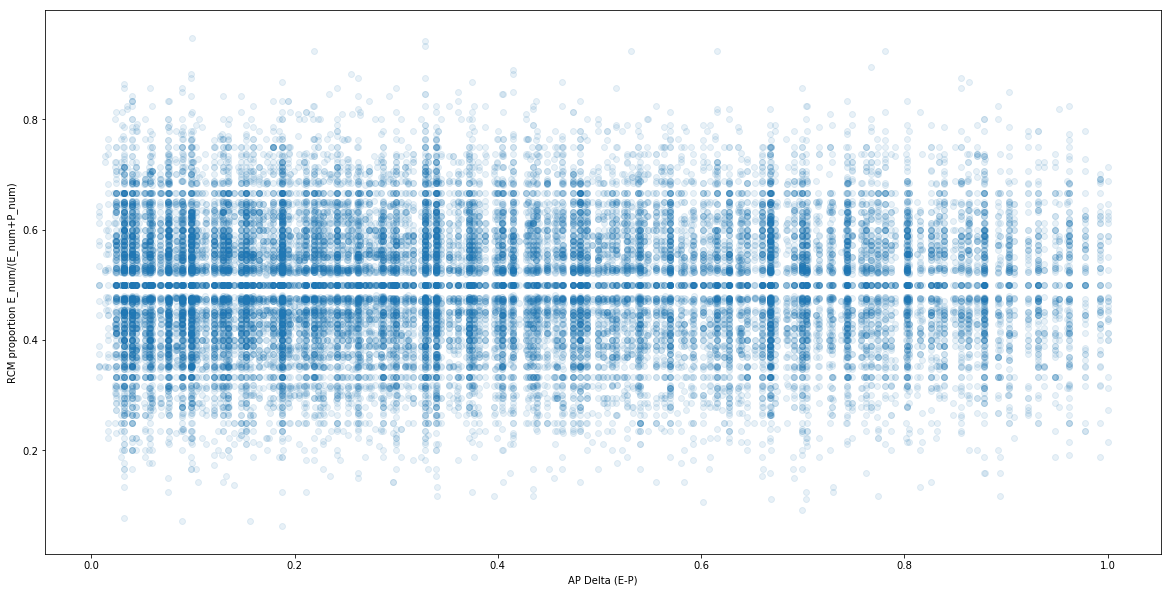

In [33]:
plot_online_offline(diff_avgprec,ap_rcm_qwinner_ratio,"AP Delta (E-P)","RCM proportion E_num/(E_num+P_num)")


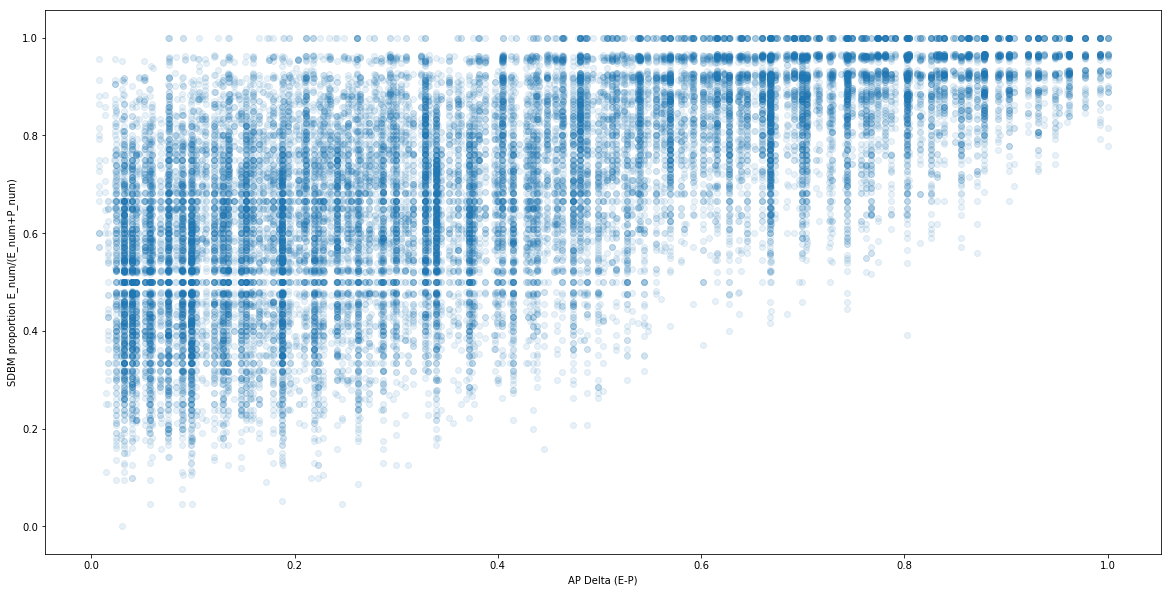

In [34]:
plot_online_offline(diff_avgprec,ap_sdbm_qwinner_ratio,"AP Delta (E-P)","SDBM proportion E_num/(E_num+P_num)")

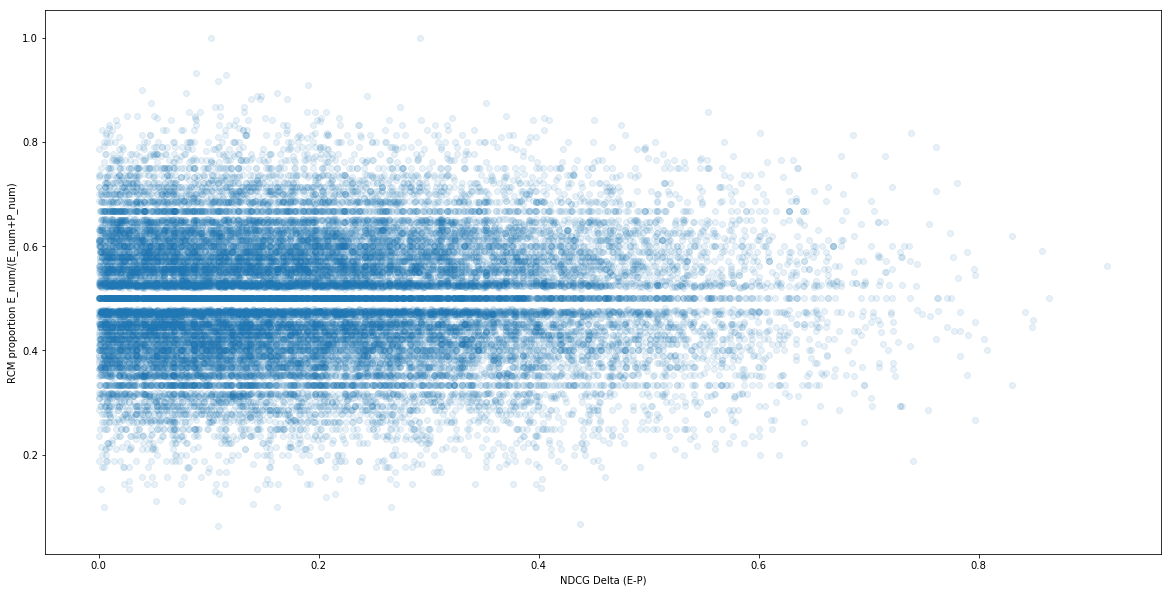

In [35]:
plot_online_offline(diff_nDCG,ndcg_rcm_qwinner_ratio,"NDCG Delta (E-P)","RCM proportion E_num/(E_num+P_num)")

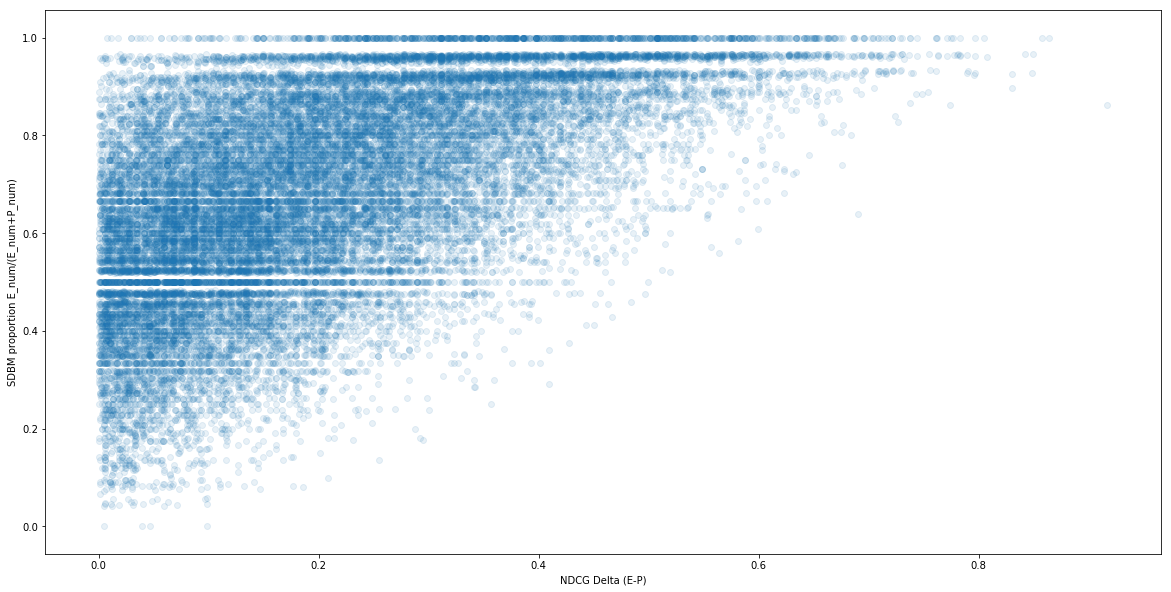

In [36]:
plot_online_offline(diff_nDCG,ndcg_sdbm_qwinner_ratio,"NDCG Delta (E-P)","SDBM proportion E_num/(E_num+P_num)")

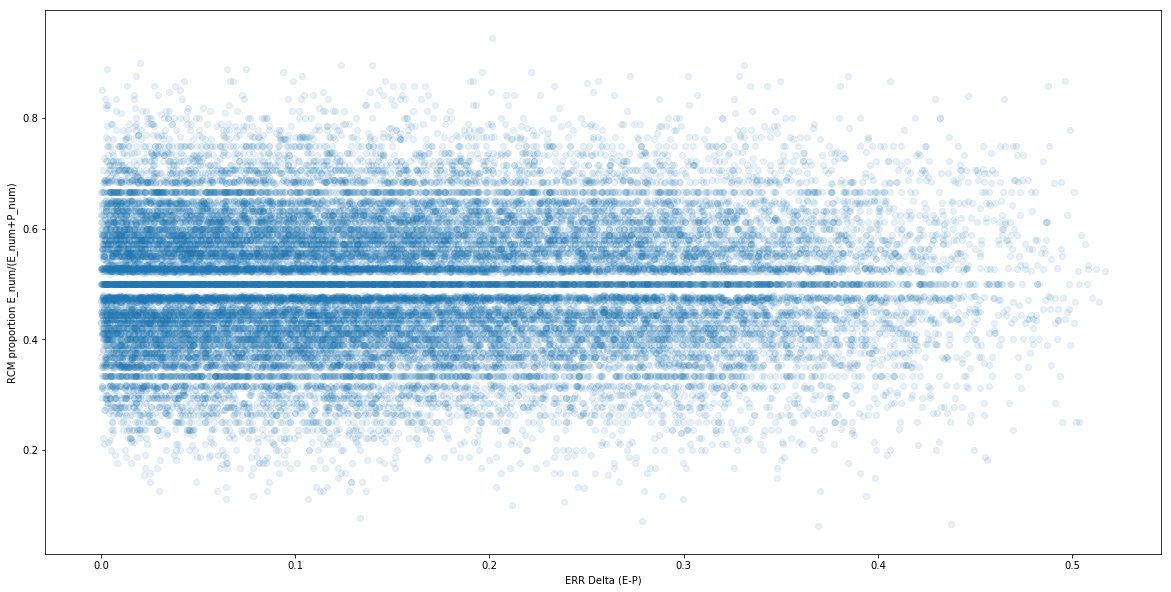

In [37]:
plot_online_offline(diff_ERR,err_rcm_qwinner_ratio,"ERR Delta (E-P)","RCM proportion E_num/(E_num+P_num)")

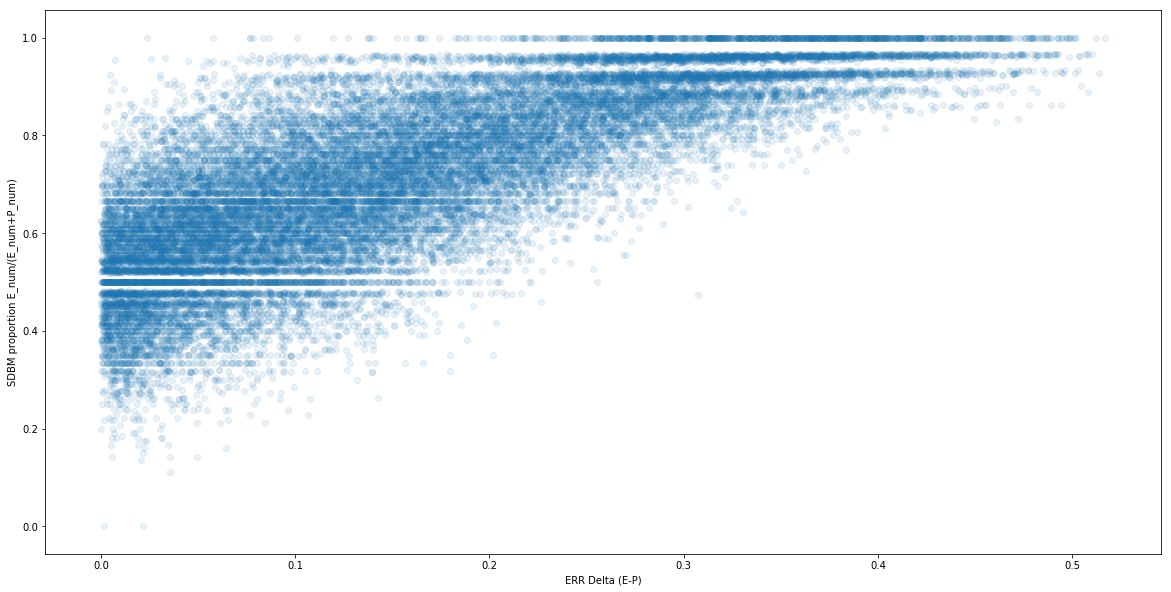

In [38]:
plot_online_offline(diff_ERR,err_sdbm_qwinner_ratio,"ERR Delta (E-P)","SDBM proportion E_num/(E_num+P_num)")

In [40]:
np.random.seed(123)

diff_measure_lists = {'precision': diff_precision, 'average precision': diff_avgprec, 
                      'nDCG': diff_nDCG, 'ERR': diff_ERR}

for measure_1, measure_2 in combinations(diff_measure_lists.keys(), 2):
    print(measure_1, 'vs.', measure_2)
    measure_1 = diff_measure_lists[measure_1]
    measure_2 = diff_measure_lists[measure_2]
    print(np.mean(measure_1), np.mean(measure_2), '\t', stats.ttest_ind(measure_1, measure_2), '\n')

precision vs. average precision
0.440397350993 0.385633681425 	 Ttest_indResult(statistic=24.810331399370998, pvalue=4.1906255886023189e-135) 

precision vs. nDCG
0.440397350993 0.205250570325 	 Ttest_indResult(statistic=137.56254633997935, pvalue=0.0) 

precision vs. ERR
0.440397350993 0.156888482957 	 Ttest_indResult(statistic=178.15802130708377, pvalue=0.0) 

average precision vs. nDCG
0.385633681425 0.205250570325 	 Ttest_indResult(statistic=102.46682270004969, pvalue=0.0) 

average precision vs. ERR
0.385633681425 0.156888482957 	 Ttest_indResult(statistic=137.7343976707223, pvalue=0.0) 

nDCG vs. ERR
0.205250570325 0.156888482957 	 Ttest_indResult(statistic=44.163141900375052, pvalue=0.0) 



<div style="background-color: lightyellow">
explanation/analysis?
</div>